<a href="https://colab.research.google.com/github/raghavendrapon/CodeAlpha_ProjectName/blob/main/TASK_3_Handwritten_Character_Recognition_EMNIST(Characters).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
crawford_emnist_path = kagglehub.dataset_download('crawford/emnist')
hasin023_testing_data_path = kagglehub.dataset_download('hasin023/testing-data')
hasin023_testing_images_path = kagglehub.dataset_download('hasin023/testing-images')
hasin023_emnist_symbol_merged_path = kagglehub.dataset_download('hasin023/emnist-symbol-merged')
hasin023_testing_math_symbols_path = kagglehub.dataset_download('hasin023/testing-math-symbols')

print('Data source import complete.')


100%|██████████| 79.3k/79.3k [00:00<00:00, 42.3MB/s]

Extracting files...


100%|██████████| 820k/820k [00:00<00:00, 51.7MB/s]

Extracting files...


100%|██████████| 285M/285M [00:04<00:00, 60.2MB/s]

Extracting files...


100%|██████████| 20.1k/20.1k [00:00<00:00, 20.8MB/s]

Extracting files...
Data source import complete.


# Hand Writing Recognition - EMNIST

# 1. Load Dataset

Firstly, we neeed to load the data. The EMNIST dataset can be included directly from kaggle. [EMNIST (Extended MNIST)](https://www.kaggle.com/datasets/crawford/emnist)

In [2]:
## Check all the contents in the emnist dataset
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/emnist/emnist-letters-mapping.txt
/kaggle/input/emnist/emnist-letters-test.csv
/kaggle/input/emnist/emnist-mnist-mapping.txt
/kaggle/input/emnist/emnist-digits-train.csv
/kaggle/input/emnist/emnist-bymerge-mapping.txt
/kaggle/input/emnist/emnist-balanced-train.csv
/kaggle/input/emnist/emnist-digits-test.csv
/kaggle/input/emnist/emnist-balanced-test.csv
/kaggle/input/emnist/emnist-mnist-test.csv
/kaggle/input/emnist/emnist-letters-train.csv
/kaggle/input/emnist/emnist-byclass-train.csv
/kaggle/input/emnist/emnist-bymerge-test.csv
/kaggle/input/emnist/emnist-balanced-mapping.txt
/kaggle/input/emnist/emnist-mnist-train.csv
/kaggle/input/emnist/emnist-digits-mapping.txt
/kaggle/input/emnist/emnist-bymerge-train.csv
/kaggle/input/emnist/emnist-byclass-test.csv
/kaggle/input/emnist/emnist-byclass-mapping.txt
/kaggle/input/emnist/emnist_source_files/emnist-digits-test-labels-idx1-ubyte
/kaggle/input/emnist/emnist_source_files/emnist-bymerge-train-labels-idx1-ubyte
/kaggle/input/

# 2. Load Libraries

Now we need to load our libraries.

In [3]:
import math
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Sequential, load_model
from keras import layers
from keras.layers import (
    Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,
    GlobalAveragePooling2D, LeakyReLU, AvgPool2D, BatchNormalization, Reshape
)
from keras.utils import Sequence, to_categorical
from keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, Callback,
    LearningRateScheduler
)
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import (
    cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
)
from sklearn.utils import class_weight

from tqdm import tqdm
import nltk

print(tf.__version__)

2.18.0


# 3. Data Preprocessing

Before building any machine learning (ML) model, it is essential to preprocess the data. In fact, data preprocessing typically takes the most time in any ML pipeline.

### About the dataset

The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
- Each row is a separate image
- 785 columns
- First column = class_label (the target variable)
- Each column after represents one pixel value (784 total for a 28 x 28 image)

**We have 112800 rows (images), each described using 784 variables 28X28 pixels plus one column as output variable (the first column)**

In [ ]:
train_df = pd.read_csv('/kaggle/input/emnist/emnist-balanced-train.csv', header=None)
train_df.head()

In [5]:
train_df.shape

(112800, 785)

In [6]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,112800.00000,112800.0,112800.0,112800.0,112800.0,112800.000000,112800.000000,112800.000000,112800.000000,112800.000000,...,112800.000000,112800.0,112800.0,112800.000000,112800.000000,112800.0,112800.0,112800.0,112800.0,112800.0
mean,23.00000,0.0,0.0,0.0,0.0,0.001365,0.011560,0.020700,0.017438,0.018475,...,0.000310,0.0,0.0,0.002163,0.000284,0.0,0.0,0.0,0.0,0.0
std,13.56472,0.0,0.0,0.0,0.0,0.235046,1.221826,1.658797,1.602478,1.719549,...,0.104211,0.0,0.0,0.726499,0.095279,0.0,0.0,0.0,0.0,0.0
min,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,11.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,23.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,35.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,46.00000,0.0,0.0,0.0,0.0,63.000000,192.000000,217.000000,217.000000,217.000000,...,35.000000,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


## 3.1 Creating label dictionary

The output variables' values comprise of 0 to 46 values where 0-9 stands for 0-9 numbers, 10-35 stands for uppercase A-Z and 35+ stand for lowercase alphabets. We will thus create a dictionary which will have these as key and value pairs.

In our dataset, there is a file emnist-balanced-mapping which contains the characters and their ASCII equivalents. We can have the index column as the key of the dictionary and the value ASCII code converted to char as the value of the dictionary.

In [7]:
label_map = pd.read_csv("/kaggle/input/emnist/emnist-balanced-mapping.txt",
                        delimiter=' ',
                        index_col=0,
                        header=None)

In [8]:
label_map.head()

,1
0,
0,48
1,49
2,50
3,51
4,52


In [9]:
label_dictionary = {}

for index, label in enumerate(label_map[1]):  # Accessing the second column which contains ASCII codes
    label_dictionary[index] = chr(label)

In [10]:
label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

**We only want to have the Hand Writing Recognition of Numbers and Block letters. Thus we will be dropping the lowercase characters from the dataset.**

## 3.2 Resetting Index

We filter the dataset to include only labels ranging from 0 to 35, which correspond to numbers and uppercase characters.

In [11]:
train_df_new = train_df[train_df[0].isin(np.arange(0, 36))]
train_df_new

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112795,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112796,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112797,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112798,31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
train_df_new[0].describe()

,0
count,86400.000000
mean,17.500000
std,10.388355
min,0.000000
25%,8.750000
50%,17.500000
75%,26.250000
max,35.000000


**The min value is 0 and max value is 35. Thus, only numbers and uppercase characters are there in the new dataframe.**

In [13]:
train_df_new.reset_index(inplace=True)
train_df_new

,index,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,3,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,32,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,112795,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86396,112796,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86397,112797,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86398,112798,31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**We will next split this output variable (y) from the input variables (x)**



Now, we separate the input (x_train) and output (y_train) variables and Check the shape of the input and output variables:

In [14]:
x_train = train_df_new.loc[:, 1:]
y_train = train_df_new.loc[:, 0]

x_train.shape, y_train.shape

((86400, 784), (86400,))

## 3.3 Visualizing Data

In [15]:
sample_image = x_train.iloc[1000]
sample_label = y_train.iloc[1000]
sample_image.shape, sample_label

((784,), np.int64(19))

Label entry No. 1000: J


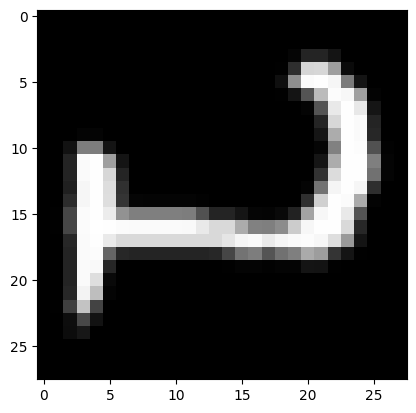

In [16]:
W = 28
H = 28

print("Label entry No. 1000:", label_dictionary[sample_label])
plt.imshow(sample_image.values.reshape(W, H), cmap=plt.cm.gray)
plt.show()

**We can see the image is rotated anticlockwise 90 degrees and flipped as well. We will thus define a function to rotate and flip and see if it works on the sample image.**

Label entry 1000: J


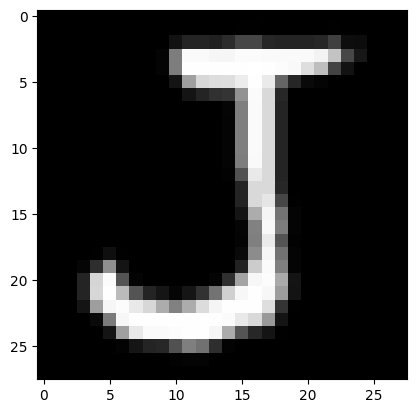

In [17]:
def flip_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

print("Label entry 1000:", label_dictionary[sample_label])
plt.imshow(flip_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()

**Now we want to apply reshape_and_rotate to all images in X_train**

In [18]:
x_train = np.apply_along_axis(flip_and_rotate, 1, x_train.values)
x_train.shape

(86400, 28, 28)

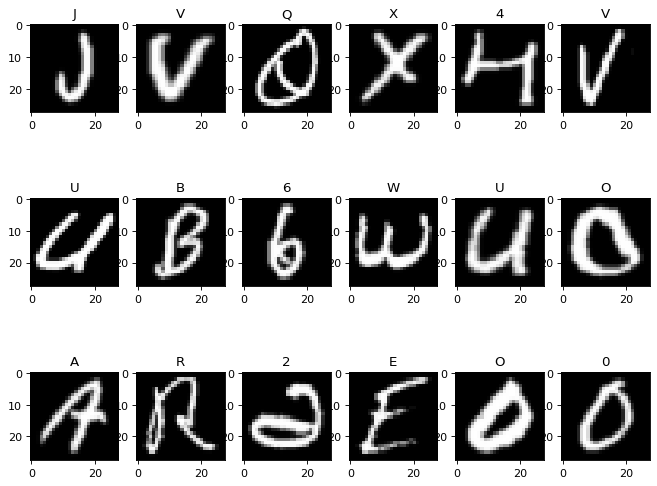

In [19]:
plt.figure(figsize=(10, 8), dpi=80)
for i in range(100, 118):
    plt.subplot(3,6,i-99)
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_train[i]])

## 3.4 Normalizing the Data

We scale the input values to bring them within the range 0 to 1 for better performance in neural network training.

In [20]:
#Data Scaling to bring the input values between 0 to 1
x_train = x_train.astype('float32') / 255
x_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00784314, 0.03529412, 0.1254902 ,
        0.01176471, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.1333

## 3.5 One Hot Encoding of the Output Labels

Since the output values are integers ranging from 0 to 35, we perform one-hot encoding to convert them into a format suitable for classification. This results in multiple output columns with binary class labels (0s and 1s).

In [21]:
#Finding the number of output columns
number_of_classes = y_train.nunique()
number_of_classes

36

**We use to_categorical() from Keras to convert the labels into one-hot encoded format.**

In [22]:
#One hot encoding of numpy array
y_train = to_categorical(y_train, number_of_classes)
y_train.shape

(86400, 36)

## 3.6 Reshaping the train data

Since TensorFlow requires a 4D array in the format: (batch_size, width, height, channels),but our current x_train is a 3D array: (number_of_images, width, height),we need to add an additional dimension for the channel (grayscale images have 1 channel).

In [23]:
x_train.shape

(86400, 28, 28)

In [24]:
x_train = x_train.reshape(-1, W, H, 1)
x_train.shape

(86400, 28, 28, 1)

## 3.7 Train and Validation Split

To evaluate the model effectively, we split the dataset into training (90%) and validation (10%) sets. The validation set helps assess the model's performance on unseen data before testing.

In [25]:
# Split 10% validation
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size= 0.1,
                                                  random_state=88)

# 4. Model Building

We will build a CNN (Convolutional Neural Network) using Sequential from Keras. The model consists of:

- Two convolutional layers (Conv2D) with ReLU activation.
- Two max pooling layers (MaxPool2D) for dimensionality reduction.
- A flattening layer (Flatten) to convert the feature maps into a 1D vector.
- Two fully connected (dense) layers with ReLU activation.
- A final output layer with softmax activation for classification.


In [26]:
model = Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(W, H, 1)))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(number_of_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 48)     │        38,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       307,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        21,588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         3,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,384 (1.42 MB)

 Trainable params: 371,384 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

## 4.1 Fitting the model


Hyperparameters

- Batch size: 32
- Epochs: 2

In [27]:
batch_size = 32
epochs = 2

**The following code defines a custom Callback that stops training if the model reaches 99.5% accuracy.**

In [28]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy') > 0.995:
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

**We use the Adam optimizer and categorical crossentropy loss since it's a multi-class classification problem.**

In [29]:
optimizer_name = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

In [30]:
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[callbacks, early_stopping])

Epoch 1/2
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 99s 44ms/step - accuracy: 0.7170 - loss: 0.9239 - val_accuracy: 0.8805 - val_loss: 0.3228
Epoch 2/2
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 144s 45ms/step - accuracy: 0.8931 - loss: 0.2868 - val_accuracy: 0.8897 - val_loss: 0.2883


## 4.2 Plotting Accuracy and Loss

We will visualize the training and validation accuracy and loss curves over epochs to analyze the model's performance.

In [31]:
def plotgraph(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

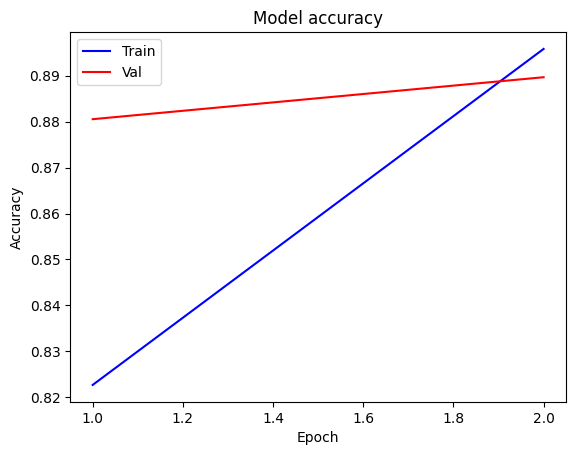

In [32]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

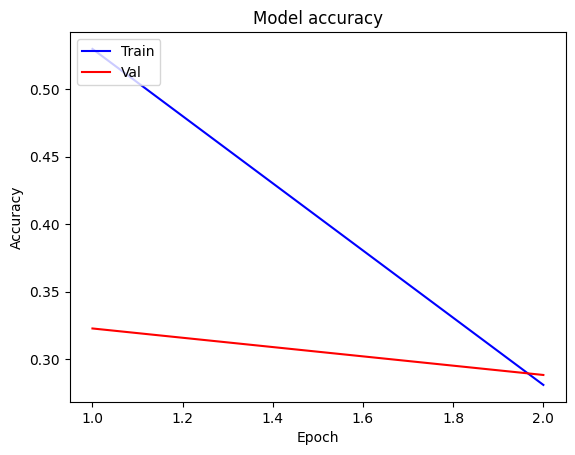

In [33]:
# loss curve
plotgraph(epochs, loss, val_loss)

### Interpretation:

- The accuracy plot helps us see how well the model is learning.
- The loss plot helps us check if the model is overfitting or underfitting.
- Ideally, training and validation curves should be close together; large gaps indicate potential overfitting.



## 4.3 Confusion Matrix

The confusion matrix provides a detailed breakdown of correct and incorrect predictions by class, allowing us to evaluate the performance of our model more comprehensively.

In [34]:
# Predict the values from the testing dataset
Y_pred = model.predict(x_val)

# Convert predictions classes to one-hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert testing observations to one-hot vectors
Y_true = np.argmax(y_val, axis=1)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


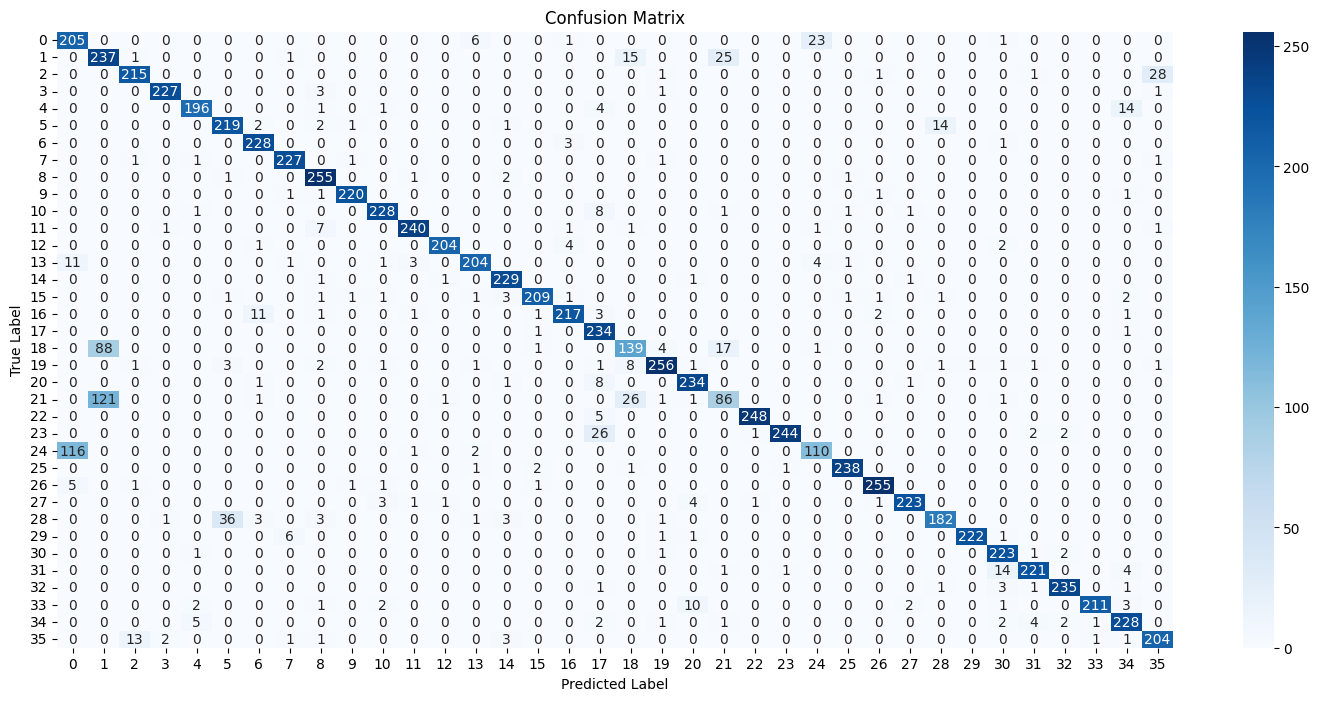

In [35]:
plt.figure(figsize=(18, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Observations

- Classes like '8', 'A', 'N', and 'W' show very high correct predictions (close to or above 249), meaning easier to predict.
- Digit '2' (Label 2) is frequently misclassified as 'Z' (Label 35).
- Letter 'D' (Label 13) has 13 misclassifications in other classes like 'O' and 'Q'.
- Letter 'I' (Label 18) shows high confusion with '1' (Label 1).
- Letter 'O' (Label 24) is confused with '0' (Label 0) with 137 misclassifications.
- Letter 'S' (Label 28) is confused with '5' (Label 5) and '8' (Label 8).

## 4.4 Plot Correct and Misclassified Samples

In [36]:
correct = np.nonzero(Y_pred_classes == Y_true)[0]
misclassified = np.nonzero(Y_pred_classes != Y_true)[0]

print("Correctly predicted classes:", correct.shape[0])
print("Misclassified predicted classes:", misclassified.shape[0])

Correctly predicted classes: 7753
Misclassified predicted classes: 887


In [37]:
def plot_images(data_index, cmap="Blues"):
    f, ax = plt.subplots(5, 5, figsize=(12, 12))
    for i, indx in enumerate(data_index[:25]):
        ax[i // 5, i % 5].imshow(x_val[indx].reshape(28, 28), cmap=cmap)
        ax[i // 5, i % 5].axis('off')
        true_label = label_dictionary[Y_true[indx]]
        pred_label = label_dictionary[Y_pred_classes[indx]]
        ax[i // 5, i % 5].set_title(f"True: {true_label}  Pred: {pred_label}")
    plt.show()

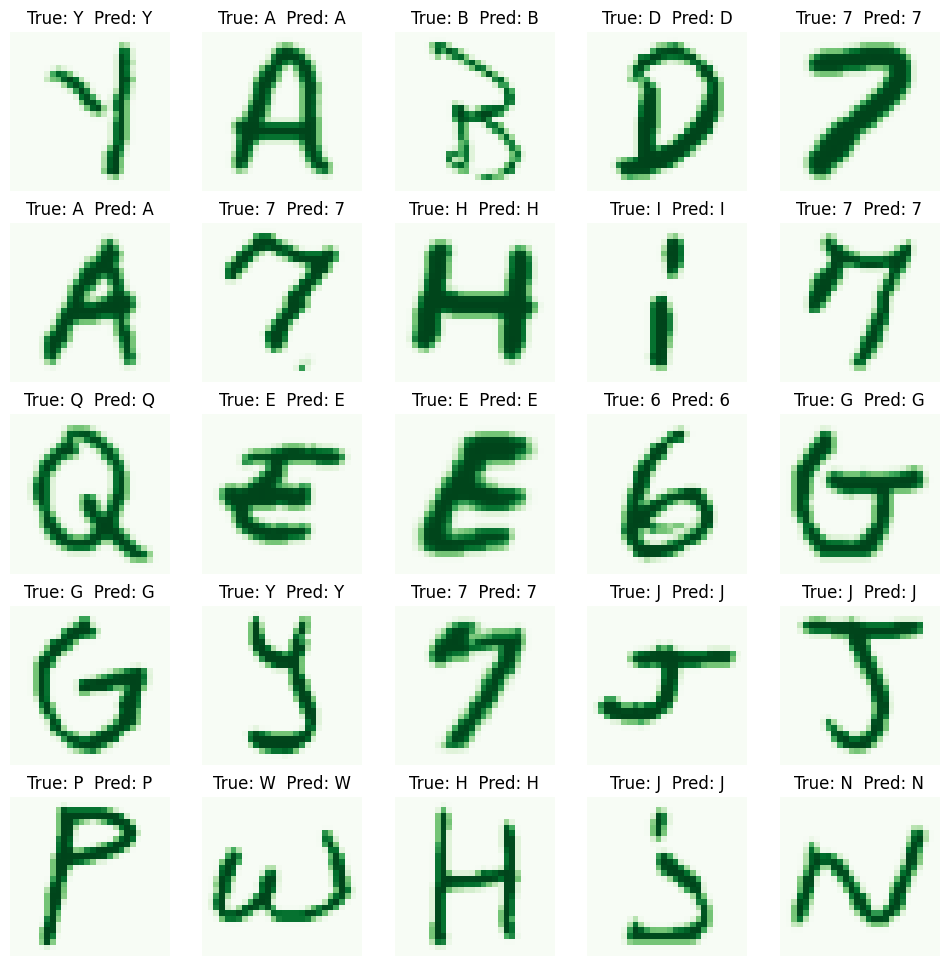

In [38]:
plot_images(correct, "Greens")

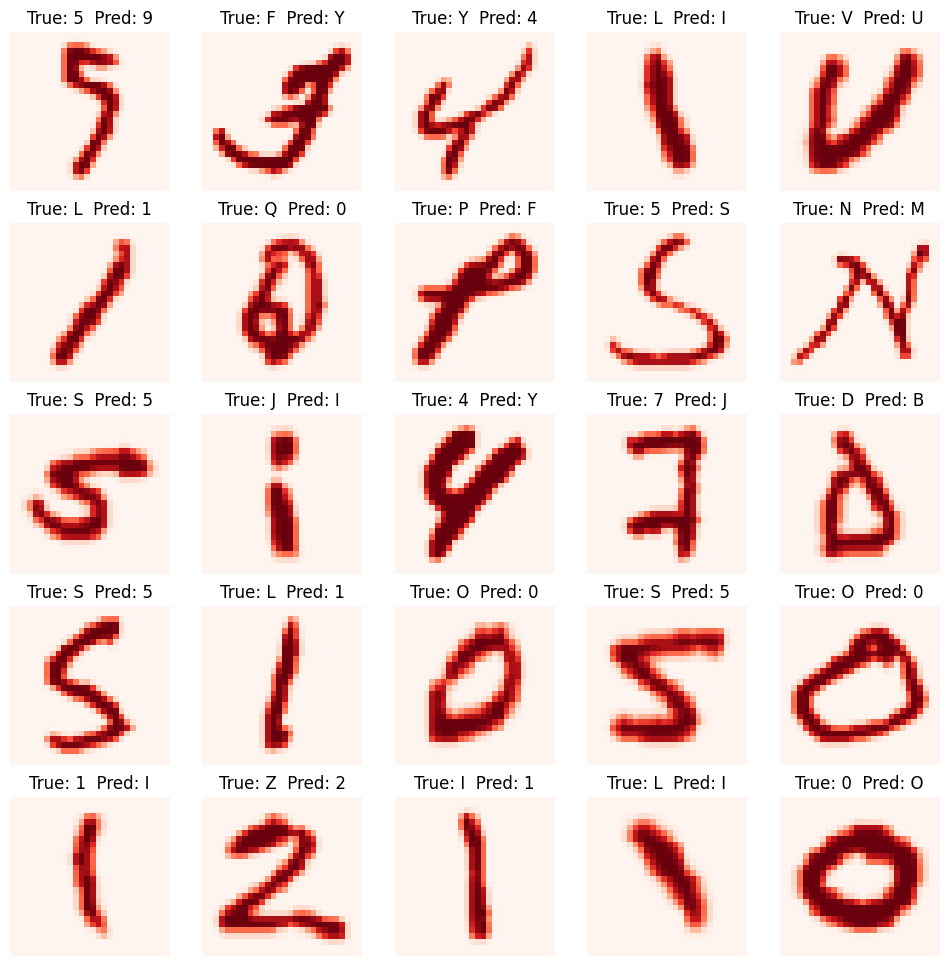

In [39]:
plot_images(misclassified, "Yellows")

## 4.5 Save the Model

The trained model is saved in the HDF5 (.h5) format, which stores both the architecture and weights.

In [40]:
model.save('writing_recognition_model.h5')
print("Model saved successfully as 'writing_recognition_model.h5'")

Model saved successfully as 'writing_recognition_model.h5'


In [43]:
# Load best model
loaded_model = load_model('writing_recognition_model.h5')
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 48)     │        38,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       307,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        21,588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         3,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,386 (1.42 MB)

 Trainable params: 371,384 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# 5. Prediction on the Validation Data

In [44]:
y_pred = loaded_model.predict(x_val)
y_pred.shape

270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


(8640, 36)

## 5.1 Visualizing some predicted values

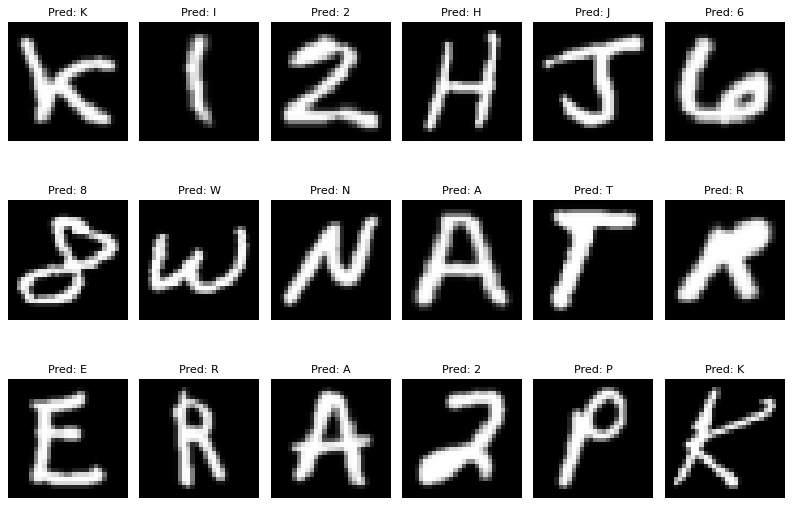

In [45]:
plt.figure(figsize=(10, 8), dpi=80)

for i in range(200, 218):
    plt.subplot(3, 6, i - 199)
    plt.imshow(x_val[i], cmap='gray')
    plt.title(f"Pred: {label_dictionary[y_pred[i].argmax()]}", fontsize=10)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 5.2 Validation Accuracy

In [46]:
val_acc = loaded_model.evaluate(x_val, y_val)
print('Loss value is ',val_acc[0])
print('Accuracy value is ',val_acc[1])

270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8990 - loss: 0.2760
Loss value is  0.283047616481781
Accuracy value is  0.8973379731178284


## 5.3 Predicting the test data

In [47]:
test_df = pd.read_csv('/kaggle/input/emnist/emnist-balanced-test.csv', header=None)
test_df.shape

(18800, 785)

In [48]:
#Removing lowercase entries
test_df_new = test_df[test_df[0].isin(np.arange(0, 36))]
test_df_new.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,14400.000000,14400.0,14400.0,14400.0,14400.0,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,...,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0
mean,17.500000,0.0,0.0,0.0,0.0,0.007917,0.025764,0.014722,0.012222,0.014722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,10.388655,0.0,0.0,0.0,0.0,0.604236,2.012452,1.204803,1.019562,1.733652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,8.750000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,17.500000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,26.250000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,35.000000,0.0,0.0,0.0,0.0,63.000000,213.000000,108.000000,95.000000,208.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
#Splitting into x and y
x_test = test_df_new.loc[:, 1:]
y_test = test_df_new.loc[:, 0]

x_test.shape, y_test.shape

((14400, 784), (14400,))

In [50]:
#Flipinng and rotating

x_test = np.apply_along_axis(flip_and_rotate, 1, x_test.values)
y_test = to_categorical(y_test, number_of_classes)

x_test.shape, y_test.shape

((14400, 28, 28), (14400, 36))

In [51]:
#Normalisation
x_test = x_test.astype('float32') / 255

In [52]:
#Reshaping (Changing Dimension)
x_test = x_test.reshape(-1, W, H, 1)
x_test.shape

(14400, 28, 28, 1)

In [53]:
#Evaluating Model
test_acc = loaded_model.evaluate(x_test, y_test)
print('Loss value is ',test_acc[0])
print('Accuracy value is ',test_acc[1])

450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8972 - loss: 0.2910
Loss value is  0.28496497869491577
Accuracy value is  0.8974999785423279


In [54]:
#Prediction
y_pred_test = loaded_model.predict(x_test)
y_pred_test.shape

450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


(14400, 36)

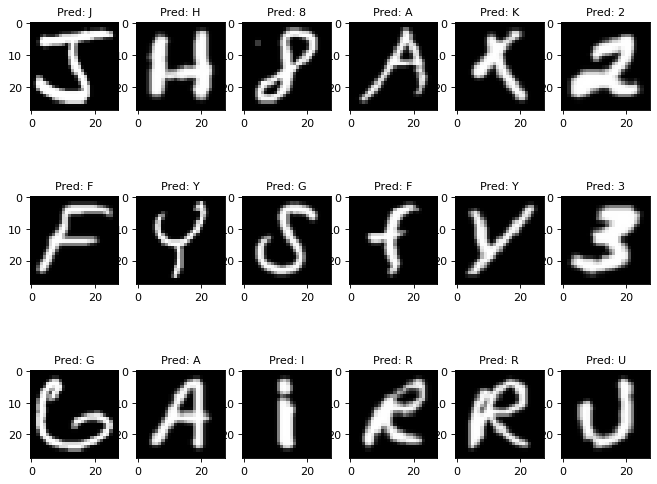

In [55]:
plt.figure(figsize=(10, 8), dpi=80)

for i in range(200, 218):
    plt.subplot(3,6,i-199)
    plt.imshow(x_test[i], cmap=plt.cm.gray)
    plt.title(f"Pred: {label_dictionary[y_pred_test[i].argmax()]}", fontsize=10)

# 6. Testing on new image

## 6.1 Preprocessing the Image

- Convert to Grayscale
- Invert Colors (Black → White, White → Black)
- Resize to 28×28 Pixels
- Reshape to Match Model Input Format

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Correct the image path to load an image from the testing-images dataset
# img = cv2.imread('/kaggle/input/testing-images/ex2.jpg')

# Instead of loading from file, use a sample image from the training data
# Assuming x_val and y_val are available from previous steps
if 'x_val' in locals() and len(x_val) > 0:
    sample_image_array = x_val[0] # Use the first image from the validation set
    sample_label = y_val[0]

    # The image from x_val is already preprocessed (normalized and reshaped)
    # We need to reverse the reshaping and normalization for displaying purposes if needed,
    # but for prediction, the x_val format is already correct.

    # For prediction, we can directly use sample_image_array
    gray_reshaped = sample_image_array

    # Ensure the shape is (1, 28, 28, 1) for prediction
    if gray_reshaped.shape != (1, 28, 28, 1):
        gray_reshaped = gray_reshaped.reshape(1, 28, 28, 1)

    print(f"Using a sample image from the validation set with shape: {gray_reshaped.shape}")

else:
    print("Error: x_val not found. Please ensure the training data is loaded and split.")
    gray_reshaped = None # Set to None if x_val is not available

# The rest of the prediction code can follow here, using gray_reshaped
# ... (prediction code will be in the next steps)

Using a sample image from the validation set with shape: (1, 28, 28, 1)


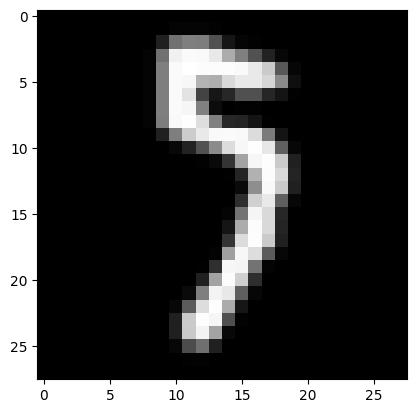

In [59]:
plt.imshow(gray_reshaped[0], cmap=plt.cm.gray)

In [60]:
y_pred_test1 = loaded_model.predict(gray_reshaped)
y_pred_test1.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


(1, 36)

In [61]:
label_dictionary[y_pred_test1.argmax()]

'9'

Text(0.5, 1.0, '9')

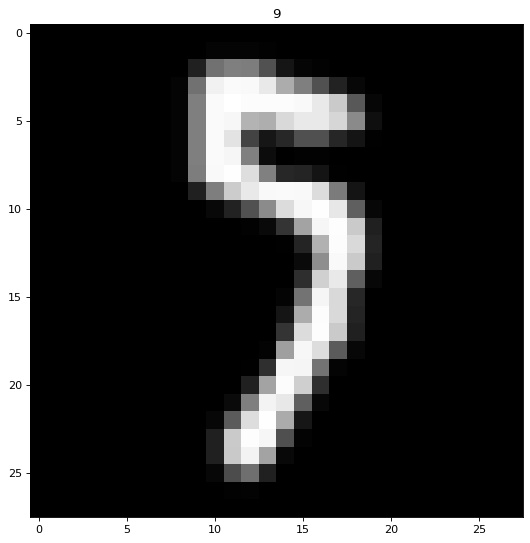

In [62]:
plt.figure(figsize=(10, 8), dpi=80)
plt.imshow(gray_reshaped[0], cmap=plt.cm.gray)
plt.title(label_dictionary[y_pred_test1[0].argmax()])

### Final Output

- The trained model predicts the letter correctly.
- We successfully preprocessed, reshaped, and tested the image.
- The final visualization shows the predicted character.



# 7. Using with segmented images

In [65]:
import sys
import cv2 as cv
import numpy as np
from pathlib import Path
from IPython.display import Image, display
import glob
import matplotlib.pyplot as plt
import uuid
import datetime
import os # Import os module

def read(path):
    img = cv.imread(str(path), 0)
    if img is None:
        sys.exit("Error! Invalid path")
    return img


def resize(img, width=600):
    b = width
    a = b / img.shape[1]
    return cv.resize(img, (b, int(img.shape[0] * a)), interpolation=cv.INTER_AREA)


def apply_thresh(img):
    return cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 155, 20)

def get_box_coords(cnts):
    boxes = np.zeros((len(cnts), 4), dtype='uint8')
    for i, cnt in enumerate(cnts):
        x, y, w, h = cv.boundingRect(cnt)
        boxes[i] = x, y, w, h
    return boxes


def get_area_wise_order(cnts):
    areas = [cv.contourArea(cnt) for cnt in cnts]
    return np.argsort(areas)[::-1]


def squarify(img):
    axis_0, axis_1 = img.shape
    diff = np.abs(axis_0 - axis_1)
    pad_1 = diff // 2
    pad_2 = pad_1 + (diff % 2)
    if axis_0 > axis_1:
        return np.pad(img, ((0, 0), (pad_1, pad_2)), mode='constant', constant_values=255)
    else:
        return np.pad(img, ((pad_1, pad_2), (0, 0)), mode='constant', constant_values=255)


def get_symbol_order(boxes, threshold_y=20):
    boxes = np.array(boxes)

    # Get centers of all boxes
    centers = boxes[:, :2] + boxes[:, 2:] / 2

    # Group symbols by line based on y-coordinate
    lines = []
    current_line = [0]
    sorted_by_y = np.argsort(centers[:, 1])

    for idx in sorted_by_y[1:]:
        y_diff = abs(centers[idx, 1] - centers[current_line[0], 1])
        if y_diff <= threshold_y:
            current_line.append(idx)
        else:
            # Sort current line by x-coordinate
            current_line.sort(key=lambda i: centers[i, 0])
            lines.append(current_line)
            current_line = [idx]

    # Add last line
    if current_line:
        current_line.sort(key=lambda i: centers[i, 0])
        lines.append(current_line)

    # Flatten the lines into final order
    return [idx for line in lines for idx in line]

def generate_equation_name():
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    short_uuid = str(uuid.uuid4())[:8]
    return f"equation_{timestamp}_{short_uuid}"



def save_all_masks(img, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Find contours
    cnts, _ = cv.findContours(255 - img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    pad_x = 2
    pad_y = 2

    # Create initial mask
    mask = np.ones(img.shape, np.uint8) * 255
    for cnt in cnts:
        cv.drawContours(mask, [cnt], 0, (0, 0, 0), -1)

    # Process contours
    cnts, _ = cv.findContours(255 - mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnts = list(cnts)

    # Get bounding boxes and filter by size
    boxes = []
    symbols = []
    temp = img.copy()
    max_size = max(cv.contourArea(cnt) for cnt in cnts) if cnts else 0 # Handle case with no contours

    for cnt in cnts:
        if cv.contourArea(cnt) > max_size / 20:  # Filter out noise
            x, y, w, h = cv.boundingRect(cnt)
            boxes.append([x, y, w, h])

            # Extract and process symbol
            symbol = temp[y:y + h, x:x + w]
            symbol = np.pad(symbol, ((pad_y, pad_y), (pad_x, pad_x)),
                          mode='constant', constant_values=255)
            symbol = squarify(symbol)
            symbols.append(symbol)

            # Mark processed region
            temp[y:y + h, x:x + w] = 255

    # Get correct symbol order
    order = get_symbol_order(boxes)

    # Save symbols in correct order and draw boxes
    ordered_paths = []
    for i, idx in enumerate(order):
        # Save symbol
        symbol_path = str(Path(output_dir) / f'{i:03d}.png')
        cv.imwrite(symbol_path, symbols[idx])
        ordered_paths.append(symbol_path)

        # Draw box with order number
        x, y, w, h = boxes[idx]
        cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
        cv.putText(img, str(i), (x, y - 5),
                  cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # Save image with numbered boxes
    cv.imwrite(str(Path(output_dir) / 'image_with_boxes.png'), img)

    return ordered_paths

def process_equation(img_array): # Modified to accept image array
    equation_name = generate_equation_name()
    output_dir = Path("/kaggle/working/output") / equation_name

    # The input is now an image array, no need to read from path
    # img = read(img_path)
    resize_img = resize(img_array, 600) # Use the input image array
    temp = apply_thresh(resize_img)

    # Save the segmented symbols and get their paths in order
    ordered_paths = save_all_masks(temp, output_dir)

    return output_dir, ordered_paths

In [67]:
# img_path = "/kaggle/input/testing-images/ex2.jpg"
# Assuming sample_image_array is available from a previous cell (e.g., DACnBtlIBSkq)
if 'sample_image_array' in locals() and sample_image_array is not None:
    # Ensure the image is in the correct format for process_equation (8-bit grayscale)
    image_for_processing = sample_image_array.copy() # Create a copy to avoid modifying the original x_val

    # If the sample image has a channel dimension, remove it
    if image_for_processing.ndim == 4 and image_for_processing.shape[0] == 1:
        image_for_processing = image_for_processing[0, :, :, 0] # Remove batch and channel dim
    elif image_for_processing.ndim == 3 and image_for_processing.shape[-1] == 1:
         image_for_processing = image_for_processing[:, :, 0] # Remove channel dim
    elif image_for_processing.ndim == 4 and image_for_processing.shape[-1] == 1:
         image_for_processing = image_for_processing[0, :, :, 0] # Handle case where batch size is 1 but not explicitly checked

    # Convert the image to 8-bit unsigned integer format (0-255)
    image_for_processing = (image_for_processing * 255).astype(np.uint8)


    output_dir, ordered_paths = process_equation(image_for_processing)
    print(f"Processed symbols saved to: {output_dir}")
    print(output_dir)
    print(ordered_paths)
else:
    print("Error: sample_image_array not found. Please run the cell to load a sample image first.")
    output_dir = None
    ordered_paths = None

Processed symbols saved to: /kaggle/working/output/equation_20250627_154714_6a3c7162
/kaggle/working/output/equation_20250627_154714_6a3c7162
['/kaggle/working/output/equation_20250627_154714_6a3c7162/000.png']


(np.float64(-0.5), np.float64(599.5), np.float64(599.5), np.float64(-0.5))

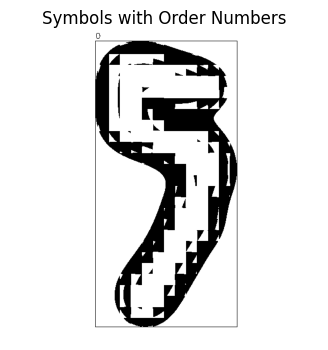

In [68]:
boxes_img = cv.imread(str(output_dir / 'image_with_boxes.png'))
boxes_img = cv.cvtColor(boxes_img, cv.COLOR_BGR2RGB)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(boxes_img)
plt.title('Symbols with Order Numbers')
plt.axis('off')

In [69]:
def predict_equation_symbols(model, ordered_paths, label_dictionary):
    predictions = []

    for path in ordered_paths:
        img = cv2.imread(path)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = 255 - gray

        # Resize image to 28x28 pixels
        gray_resized = cv2.resize(gray, (28, 28))

        # Reshape image to (1, 28, 28, 1) for model input
        gray_reshaped = gray_resized.reshape(1, 28, 28, 1)

        prediction = model.predict(gray_reshaped)
        predicted_label = label_dictionary[prediction.argmax()]

        predictions.append(predicted_label)

    return predictions

In [70]:
predicted_symbols = predict_equation_symbols(loaded_model, ordered_paths, label_dictionary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


In [71]:
predicted_symbols

['A']

# 8. Using Merged Dataset with Symbols

In [72]:
!pip install imutils

In [73]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours

In [74]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
!unzip -qo data.zip

--2025-06-27 15:48:00--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.66.72, 16.12.40.115, 52.219.160.103, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.66.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28437489 (27M) [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip            100%[===================>]  27.12M  4.50MB/s    in 15s     

2025-06-27 15:48:16 (1.84 MB/s) - ‘data.zip’ saved [28437489/28437489]



In [75]:
x = []
y = []
datadir = 'data/dataset'
for folder in os.listdir(datadir):
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)

print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

7600
7600
labels : ['9', '7', '6', '5', '3', '8', '0', 'sub', 'mul', '4', 'add', '2', 'div', '1']


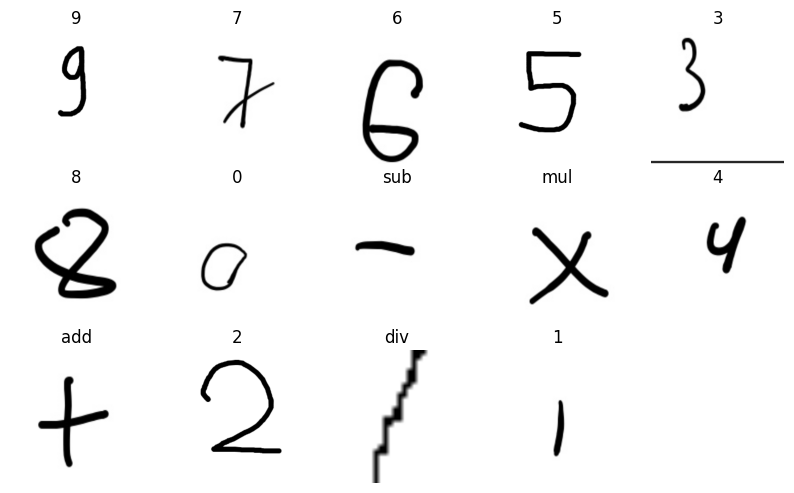

In [76]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

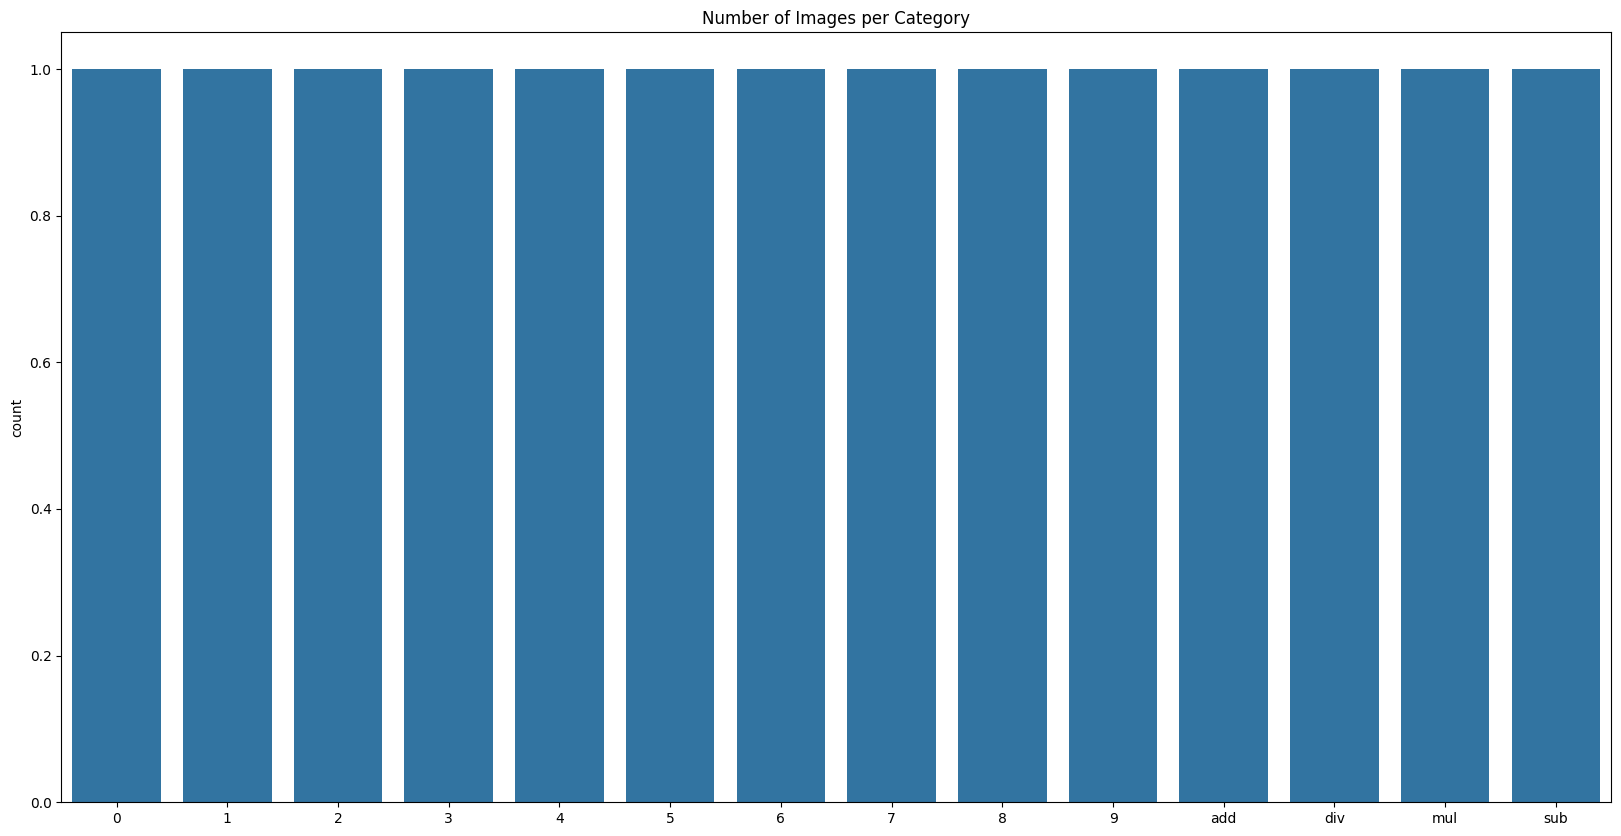

In [77]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sns.countplot(x=unique)
plt.title('Number of Images per Category')
plt.show()

In [78]:
X = []
for i in range(len(x)):
#     print(i)
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

7600


In [79]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

7600


In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

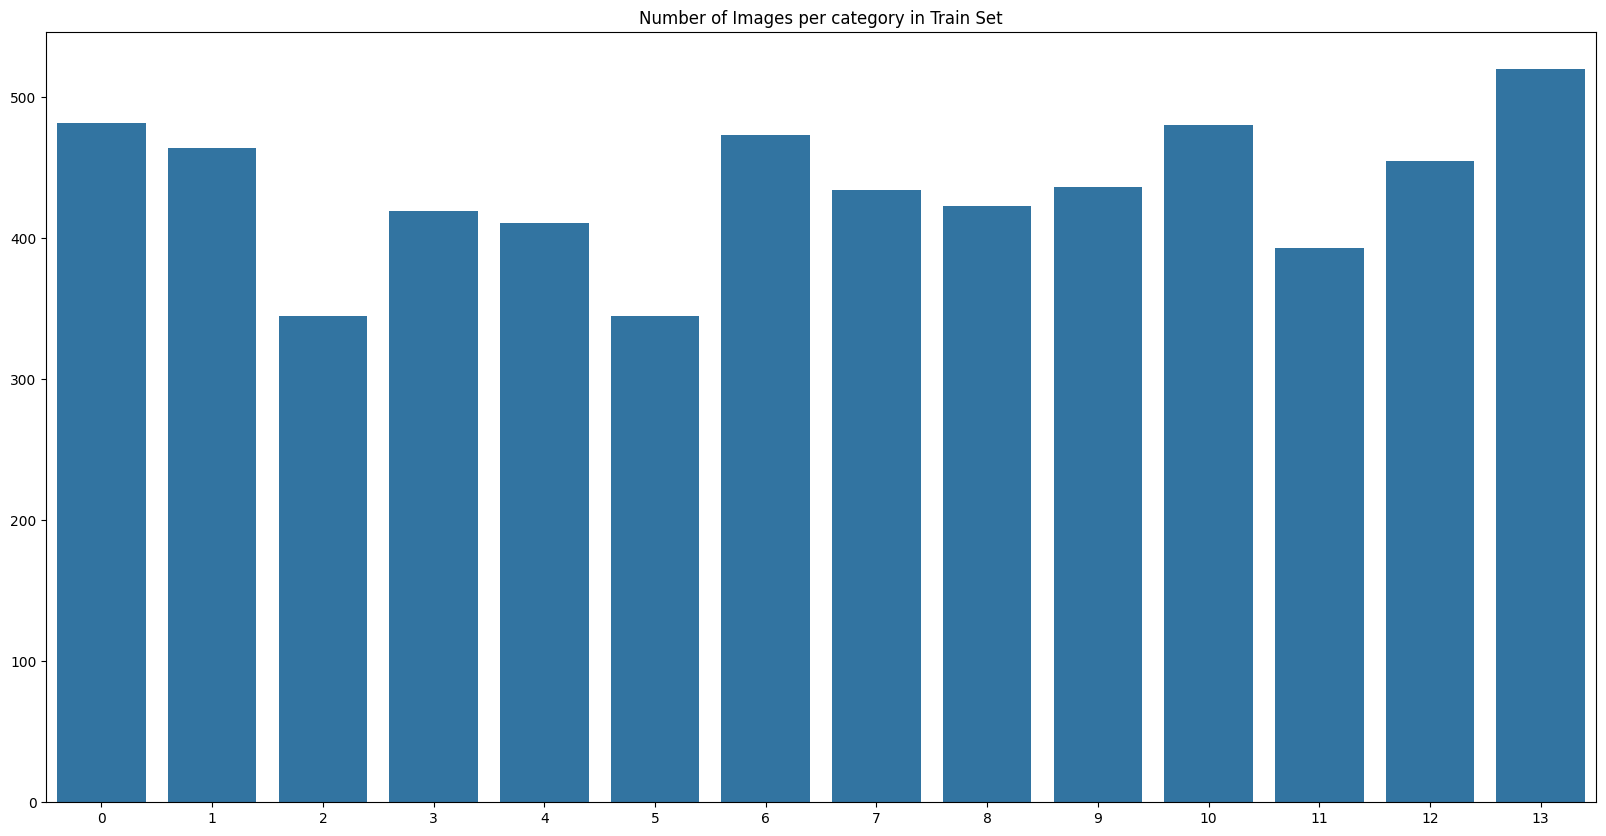

In [81]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
ax = sns.barplot(x=unique_train, y=count_train)
ax.set_title('Number of Images per category in Train Set')
plt.show()

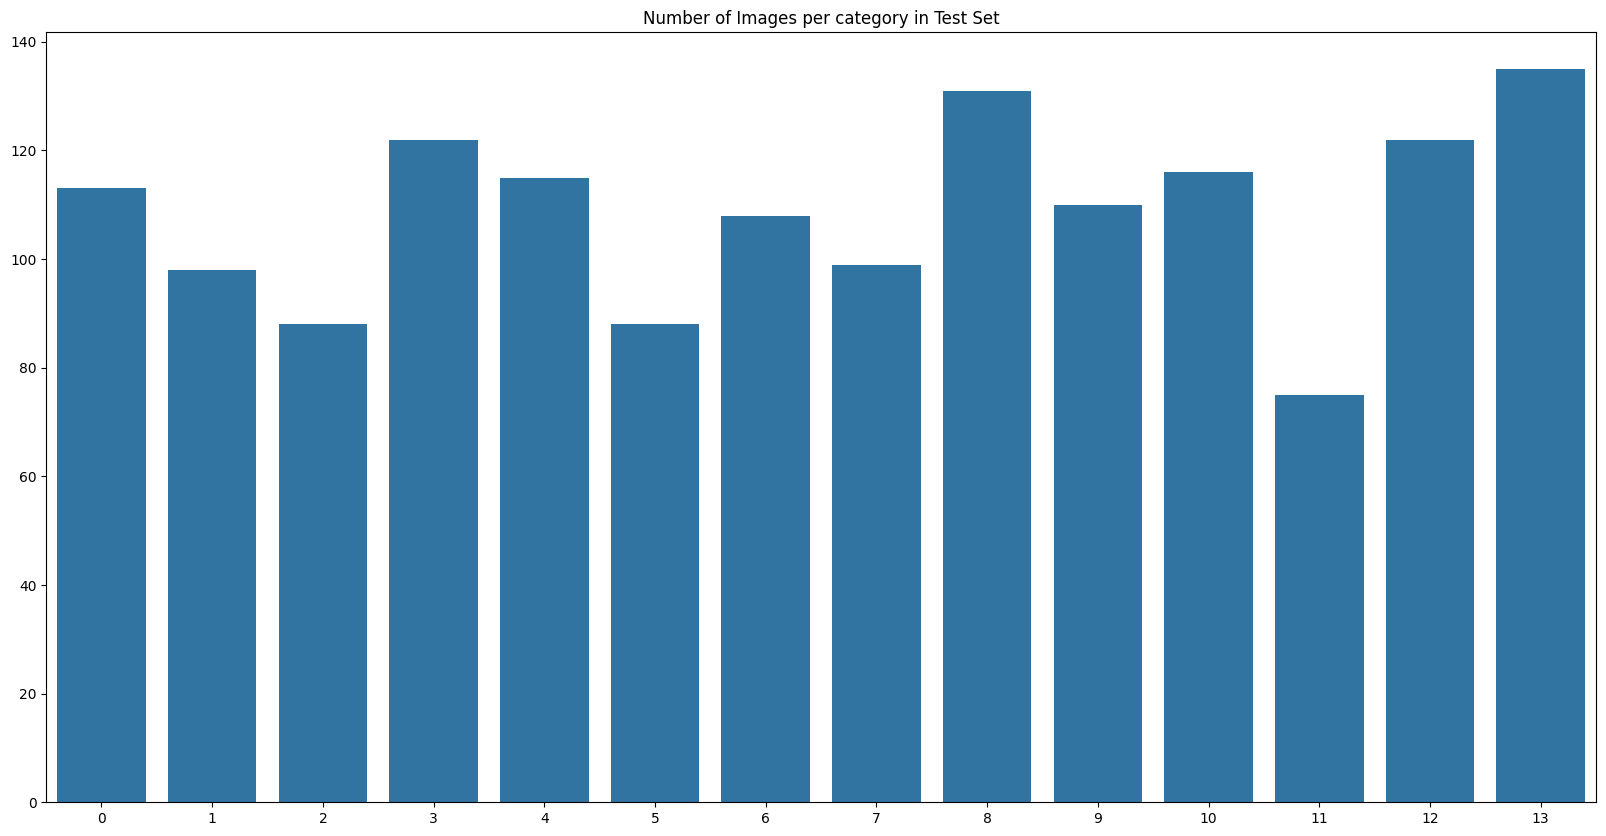

In [82]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
ax = sns.barplot(x=unique_test, y=count_test)
ax.set_title('Number of Images per category in Test Set')
plt.show()

In [83]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


In [84]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))

    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [85]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act1 (Activation)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act2 (Activation)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act3 (Activation)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 120)            │       123,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 14)             │         1,190 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,418 (634.45 KB)

 Trainable params: 162,418 (634.45 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
# Evaluate the loaded model on the test set
loss, accuracy = loaded_model.evaluate(X_test, Y_test)

print(f"Loss on test set: {loss}")
print(f"Accuracy on test set: {accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9418 - loss: 0.2484
Loss on test set: 0.2489662766456604
Accuracy on test set: 0.9375


In [126]:
aug = ImageDataGenerator(zoom_range=0.1,
                         width_shift_range=0.05,
                         height_shift_range=0.05)

hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - accuracy: 0.9382 - loss: 0.3297 - val_accuracy: 0.9592 - val_loss: 0.3475
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.9513 - loss: 0.2877 - val_accuracy: 0.9651 - val_loss: 0.3113
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.9376 - loss: 0.3218 - val_accuracy: 0.9408 - val_loss: 0.3986
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.9493 - loss: 0.3052 - val_accuracy: 0.9454 - val_loss: 0.3816
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step - accuracy: 0.9446 - loss: 0.3062 - val_accuracy: 0.9579 - val_loss: 0.3780
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.9412 - loss: 0.3260 - val_accuracy: 0.9592 - val_loss: 0.3632
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/step - accuracy: 0.9416 - loss: 0.3263 - val_accuracy: 0.9421 - val_loss: 0.3828
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.9483 - loss: 0.2932 - val_accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - accuracy: 0.9536 - loss: 0.2920 - val_accuracy: 0.9743 - val_loss: 0.2987


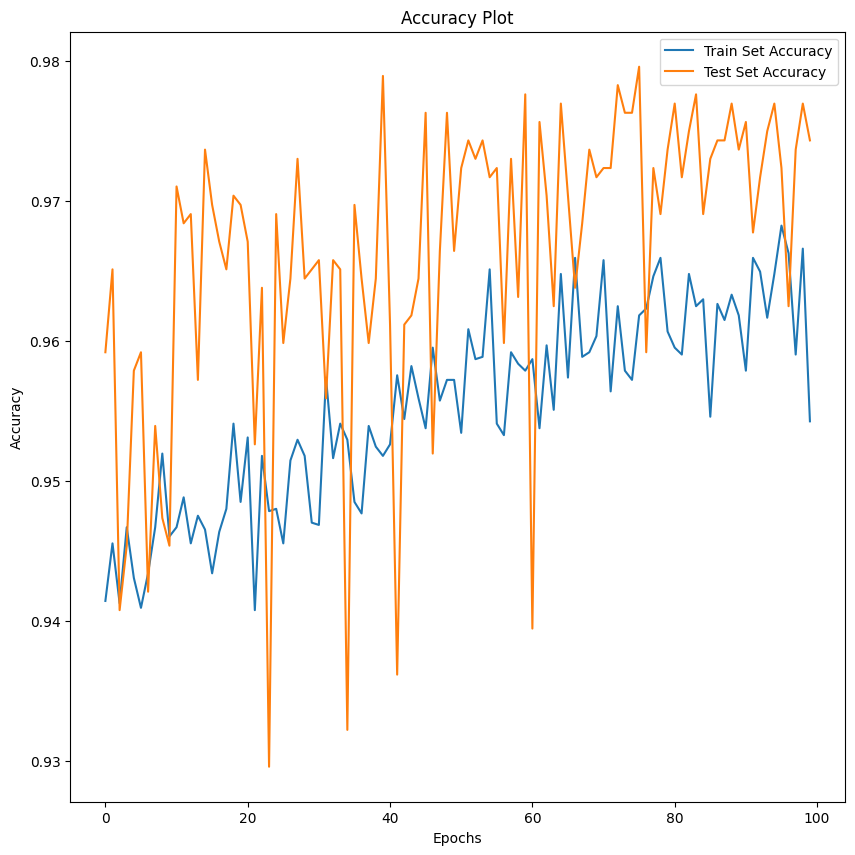

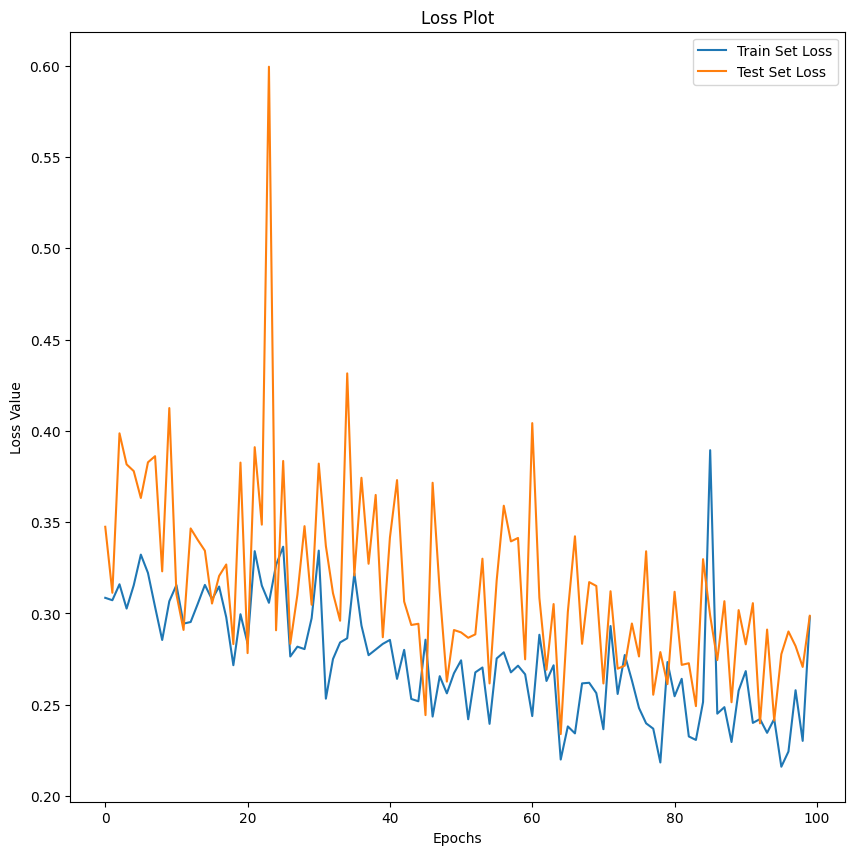

In [129]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

In [130]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       113
           1       0.98      0.97      0.97        98
           2       0.97      0.98      0.97        88
           3       1.00      0.97      0.98       122
           4       0.92      0.95      0.93       115
           5       1.00      0.98      0.99        88
           6       0.99      0.98      0.99       108
           7       0.98      0.97      0.97        99
           8       0.92      1.00      0.96       131
           9       0.93      0.99      0.96       110
          10       1.00      0.94      0.97       116
          11       1.00      1.00      1.00        75
          12       1.00      0.98      0.99       122
          13       1.00      0.99      1.00       135

    accuracy                           0.97      1520
   macro avg       0.98      0.97      0.98      1520
weighted avg       0.98      0.97      0

In [138]:
# Save only the weights in the supported .weights.h5 format
weights_path_h5 = '/kaggle/working/maths_symbol_and_digits_recognition_weights.weights.h5'
model.save_weights(weights_path_h5)

import os

# Check if the weights file exists immediately after saving
print(f"Checking for weights file immediately after saving: {weights_path_h5}")
if os.path.exists(weights_path_h5):
    file_size = os.path.getsize(weights_path_h5)
    print(f"Weights file found: {weights_path_h5}, Size: {file_size} bytes")
else:
    print(f"Weights file NOT found immediately after saving: {weights_path_h5}")

# Explicitly list the contents of the /kaggle/working/ directory
print("\nContents of /kaggle/working/ after saving attempt:")
print(os.listdir('/kaggle/working/'))

Checking for weights file immediately after saving: /kaggle/working/maths_symbol_and_digits_recognition_weights.weights.h5
Weights file found: /kaggle/working/maths_symbol_and_digits_recognition_weights.weights.h5, Size: 1999544 bytes

Contents of /kaggle/working/ after saving attempt:
['maths_symbol_and_digits_recognition_weights.weights.h5', 'output']


In [139]:
# Recreate the model architecture
loaded_model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))

# Load the weights from the .weights.h5 format
weights_path_h5 = '/kaggle/working/maths_symbol_and_digits_recognition_weights.weights.h5'
loaded_model.load_weights(weights_path_h5)

# Compile the model after loading weights
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

loaded_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act1 (Activation)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act2 (Activation)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act3 (Activation)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 120)            │       123,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 14)             │         1,190 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,418 (634.45 KB)

 Trainable params: 162,418 (634.45 KB)

 Non-trainable params: 0 (0.00 B)